# Load Dependencies 

In [253]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import Data

In [254]:
train = pd.read_csv('Data/train_features.csv')
test = pd.read_csv('Data/test_features.csv')
target = pd.read_csv('Data/train_labels.csv')
train.shape, test.shape

((59400, 40), (14358, 40))

# Select Features

In [255]:
selected_features = ['amount_tsh',
    'date_recorded',
    'gps_height',
    'basin',
    'region',
    'population',
    'public_meeting',
    'scheme_management',
    'permit',
    'construction_year',
    'extraction_type_class',
    'management_group',
    'payment',
    'quality_group',
    'quantity',
    'source_type',
    'source_class', 
    'waterpoint_type',
    'funder',
    'installer', 
    'latitude',
    'longitude']

def select_features(df, features):
    '''
    Subsets dataframe based on list of columns names accepted 
    as a parameter.
    '''
    return df[features]

In [256]:
train = select_features(train, features=selected_features)
test = select_features(test, features=selected_features)
train.shape, test.shape

((59400, 22), (14358, 22))

# Process Features 

In [257]:
def wrangle_features(X):
    X = X.copy()
    
    # Create month and year features from the recorded data feature
    X['date_recorded'] = pd.to_datetime(X['date_recorded'])
    X['date_recorded_month'] = X['date_recorded'].dt.month
    X['date_recorded_year'] = X['date_recorded'].dt.year
    
    # Bin low freq. categories into 'other'
    X['scheme_management'] = X['scheme_management'].replace({
        'SWC':'Other',
        'Trust':'Other',
        'None':'Other'
    })
    
    # Create age category out of construction_year
    # Bin 0 values as -1
    X['pump_age'] = ( 2014 - X['construction_year'] )
    X['pump_age'].replace({2014:-1}).value_counts()
    
    # Alter longitude values so all points are reasonable
    X['longitude'] = X['longitude'].replace({
        0.000000:train['longitude'].median()
    })
    
    # Create Installer Features
    X['DWE_Installer'] = (X['installer'] == 'DWE')

    one_time_install = train['installer'].value_counts()[train['installer'].value_counts() == 1]
    X['One_Time_Installer'] = X['installer'].isin(one_time_install.index)

    small_install = train['installer'].value_counts()[ (train['installer'].value_counts() < 10) & (train['installer'].value_counts() > 1) ]
    X['Small_Installer'] = X['installer'].isin(small_install.index)

    big_install = (( train['installer'].value_counts() >= 10 ) == True)
    X['Big_Installer'] = X['installer'].isin(big_install.index)
    
    # Create Funder Features
    X['Tanzania_Gov_Funder'] = (X['funder'] == 'Government Of Tanzania')

    one_time_funder = train['funder'].value_counts()[train['funder'].value_counts() == 1]
    X['One_Time_Funder'] = X['funder'].isin(one_time_funder.index)

    small_funder = train['funder'].value_counts()[ (train['funder'].value_counts() < 10) & (train['funder'].value_counts() > 1) ]
    X['Small_Funder'] = X['funder'].isin(small_funder.index)

    big_funder = (( train['funder'].value_counts() >= 10 ) == True)
    X['Big_Funder'] = X['funder'].isin(big_funder.index)
    
    # Drop unecessary columns
    drop_cols = ['date_recorded', 'funder', 'installer', 'construction_year']
    X = X.drop(columns=drop_cols)
    
    return X

In [258]:
test = wrangle_features(test)
train = wrangle_features(train)

train.shape, test.shape

KeyError: 'installer'

In [222]:
from sklearn.preprocessing import StandardScaler
def standardize(X):
    # Features to standardize
    standardize_cols = ['amount_tsh', 'gps_height', 'longitude', 
                        'latitude', 'population', ]
    
    # Silence Data Conversion warning
    X[standardize_cols] = X[standardize_cols].astype(float)
    
    # Fit and transform scaler
    scaler = StandardScaler()
    scaler.fit(train[standardize_cols])
    scaled = pd.DataFrame( scaler.transform(X[standardize_cols]) )
    
    # Add back column names
    for i in range(len(standardize_cols)):
        scaled = scaled.rename(columns={i:standardize_cols[i]})
        
    # Drop non-standardized columns
    X = X.drop(columns=standardize_cols)
    
    # Concat scaled features with rest of features
    X = pd.concat([X, scaled], axis=1)
    
    return X

In [223]:
train = standardize(train)
test = standardize(test)

train.shape, test.shape

((59400, 31), (14358, 31))

In [224]:
import category_encoders as ce

def one_hot(X):
    # Features to one hot encode
    one_hot_cols = ['date_recorded_month', 'date_recorded_year', 
                    'basin', 'region', 'extraction_type_class', 
                    'management_group', 'payment', 'quality_group', 
                    'quantity', 'source_type', 'source_class', 
                    'waterpoint_type']
    
    # Convert all relevant cols to category datatype (for encoder)
    X[one_hot_cols] = X[one_hot_cols].astype('category')
    
    # Initialize and transform relevant features
    encoder = ce.OneHotEncoder(use_cat_names=True)
    
    # Note, train hardcoded to avoid overfitting test data
    encoder.fit(train[one_hot_cols])
    X = encoder.transform(X[one_hot_cols])
    
    return X

In [225]:
processed_train = one_hot(train)
processed_test = one_hot(test)
processed_train.shape, processed_test.shape

((59400, 94), (14358, 94))

# Modeling 

In [249]:
target = pd.read_csv('Data/train_labels.csv')

In [250]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

model = RandomForestClassifier(n_estimators=250,
                              max_depth=None)

In [251]:
scores = cross_validate(model, 
                        processed_train, 
                        target['status_group'], 
                        return_train_score=True,
                        return_estimator=True,
                        scoring='accuracy', 
                        n_jobs=-1
                        cv=5)

In [252]:
pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,26.911746,1.431139,"(DecisionTreeClassifier(class_weight=None, cri...",0.777544,0.821692
1,33.981603,1.371342,"(DecisionTreeClassifier(class_weight=None, cri...",0.772662,0.823165
2,36.628517,1.343061,"(DecisionTreeClassifier(class_weight=None, cri...",0.774411,0.822727
3,32.106574,1.296582,"(DecisionTreeClassifier(class_weight=None, cri...",0.770034,0.823506
4,26.448956,1.194816,"(DecisionTreeClassifier(class_weight=None, cri...",0.770079,0.823366


In [237]:
from sklearn.metrics import accuracy_score

model.fit(processed_train, target['status_group'])

y_train_pred = model.predict(processed_train)
y_test_pred = model.predict(processed_test)

score = accuracy_score(target['status_group'], y_train_pred)
print(f'Train Accuracy Score: {score}')

Train Accuracy Score: 0.7155050505050505


# With Boosting

In [240]:
from xgboost import XGBClassifier
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [247]:
grboost = XGBClassifier(n_estimators=300,
                        max_depth=10, 
                        silent=False,
                        n_jobs=-1,
)

In [248]:
from sklearn.metrics import accuracy_score

grboost.fit(processed_train, target['status_group'])

y_train_pred = model.predict(processed_train)
y_test_pred = model.predict(processed_test)

score = accuracy_score(target['status_group'], y_train_pred)
print(f'Train Accuracy Score: {score}')

Train Accuracy Score: 0.7155050505050505


# Create Submission 

In [124]:
def create_submission(y_test_pred):
    sample_submission = pd.read_csv('Data/sample_submission.csv')
    submission = sample_submission.copy()
    submission['status_group'] = y_test_pred
    
    now = pd.to_datetime('now')
    filename = 'MB_' + str(now).replace(' ','_')[0:-7] 
    
    submission.to_csv(f'Submissions/{filename}.csv', index=False)

In [125]:
create_submission(y_test_pred)

# Review Feature Importances

In [238]:
def plot_feature_importances(model):
    '''
    Assumes at least 15 features, model must be fitted
    '''
    fi_values = model.feature_importances_
    fi = pd.DataFrame({
        'feature':processed_train.columns,
        'importance':fi_values
    })
    fi['normalized'] = fi['importance'] / fi['importance'].sum()
    fi = fi.sort_values('normalized', ascending=False).reset_index()
    plt.figure(figsize=(10,6))
    ax = plt.subplot()
    ax.barh(list(reversed(list(fi.index[:15]))),
           fi['normalized'].head(15),
           align='center', edgecolor='k')
    ax.set_yticks( list(reversed(list(fi.index[:15]))) )
    ax.set_yticklabels(fi['feature'].head(15))
    ax.set_title('Top 15 Feature Importances')
    plt.show()

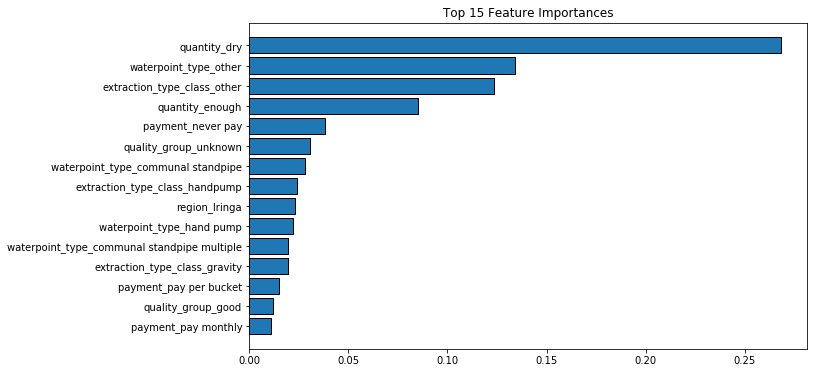

In [239]:
plot_feature_importances(model)